In [115]:
import glob

img_list = glob.glob('figs/mnistv3/*/150.jpg')
print(len(img_list))

5


In [116]:
import numpy as np
import matplotlib.pyplot as plt



def cartesian_coord(*arrays):
    grid = np.meshgrid(*arrays)        
    coord_list = [entry.ravel() for entry in grid]
    points = np.vstack(coord_list).T
    return points

def get_available_attr(img_list):
    attr_dict = {}
    for img_dir in img_list:
        for attr in img_dir.split('/')[-2].split('@'):
            attr_name, attr_value = attr.split('(')[0], attr.split('(')[1][:-1]
            if attr_name not in attr_dict.keys():
                attr_dict[attr_name] = [attr_value]
            else:
                if attr_value not in attr_dict[attr_name]: 
                    attr_dict[attr_name].append(attr_value)
    return attr_dict


def filter_results(attr_dict):
    interested_imgs = []
    attrs = []
    attr_names = list(attr_dict.keys())
    attr_list= attr_dict.values()
    
    param_combination_list = cartesian_coord(*attr_list)
    
    for i in range(len(param_combination_list)):
        param_comb= param_combination_list[i]
        
        attrs= []
        for j in range(len(param_comb)):
            attr_name = attr_names[j]
            param_value = param_comb[j]
            attrs.append(f'{attr_name}({param_value})')
            
        #print(attrs)
        for img_dir in img_list:
            flag=True
            for attr in attrs:
                #print('check : ',attr.split('('))
                if attr.split('(')[1][:-1]=='all':
                    flag=True
                    continue
                else:
                    if attr not in img_dir:
                        flag= False
                        break
            if flag==True:interested_imgs.append(img_dir)
            #else:print(img_dir)
    print(f'{len(interested_imgs)} images are found !!!')
    return interested_imgs

def show_results(key, dict_img_position, interested_imgs):
    start, end = dict_img_position[key]

    for img_dir in sorted(interested_imgs):
        plt.figure(figsize = (15,5))
        plt.imshow(plt.imread(img_dir)[start:end,:])
        plt.title(img_dir.split('/')[2])
        plt.show()


dict_img_position = {
    'main':[0, 200],
    'ht':[200, 650],
    'loss':[650, 920],
    'overall_results':[950, 1150]}

In [119]:
get_available_attr(img_list)

{'noise': ['True'], 'lr_H': ['0.01', '0.001'], 'T': ['2', '5', '16']}

In [123]:
dict_= {
    'noise' : ['True'],
    'lr_H': ['0.01', '0.001'],
    'T': ['2', '5', '16']
    }

In [121]:
interested_imgs = filter_results(dict_)
print(f'available keys : {list(dict_img_position.keys())}')

5 images are found !!!
available keys : ['main', 'ht', 'loss', 'overall_results']


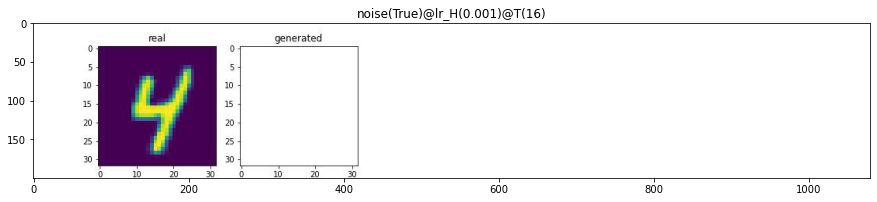

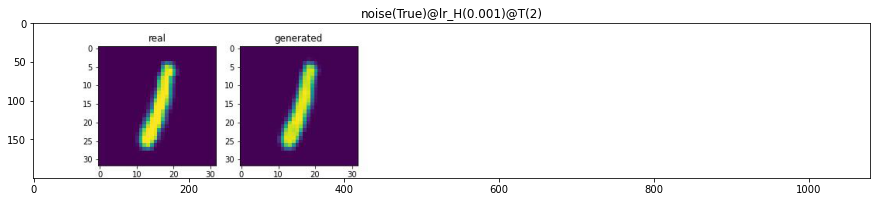

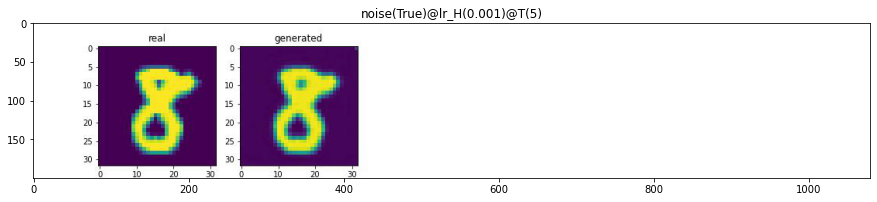

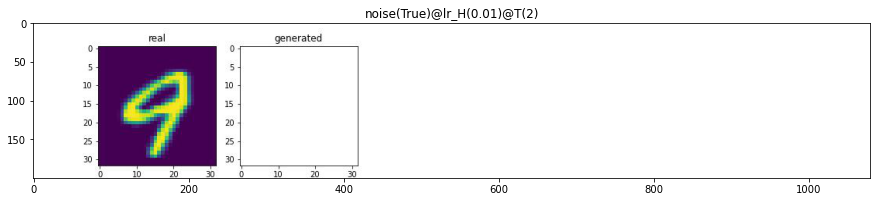

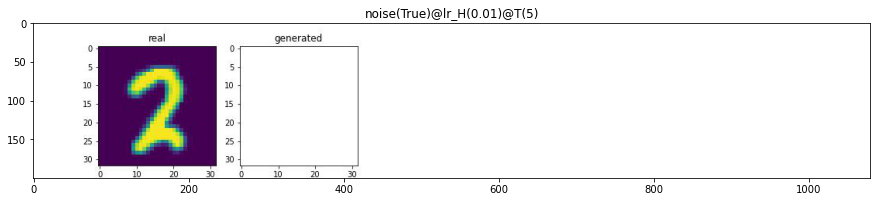

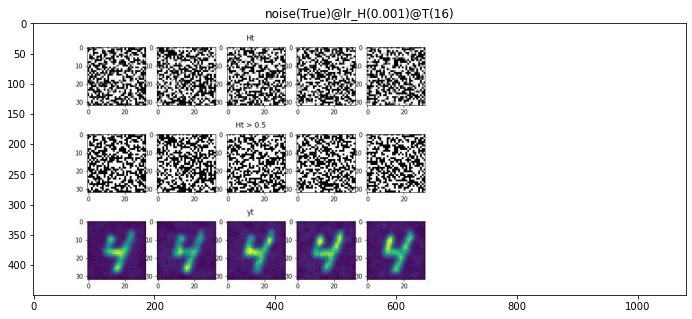

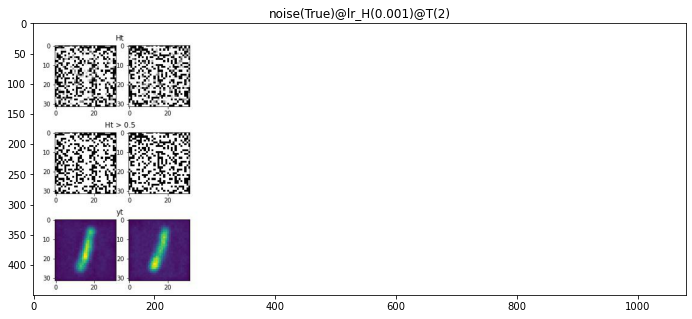

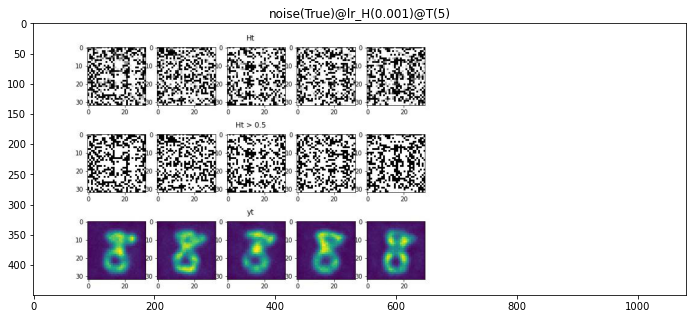

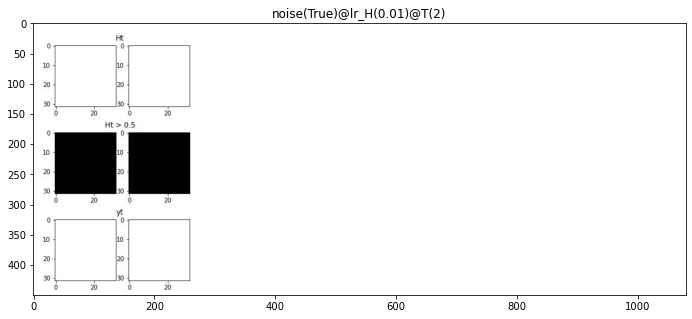

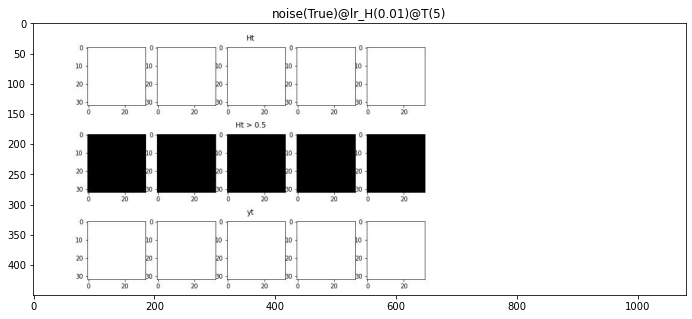

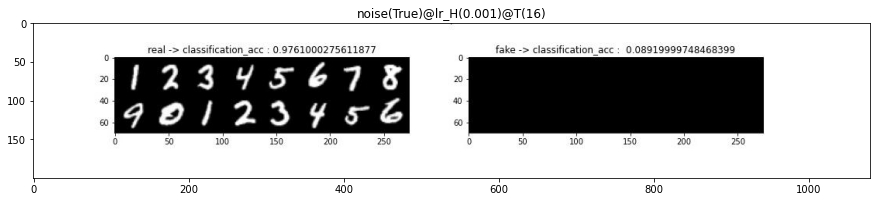

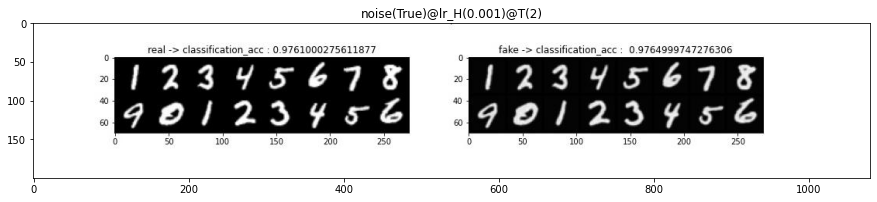

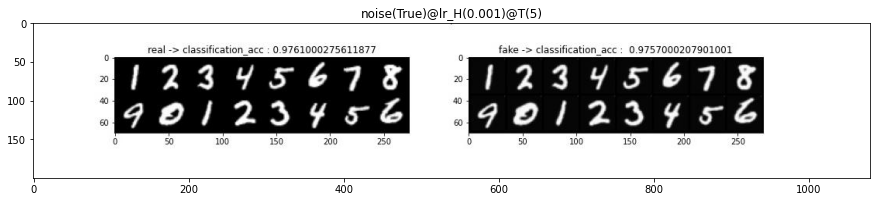

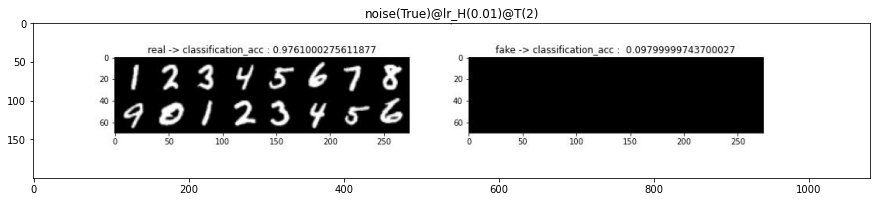

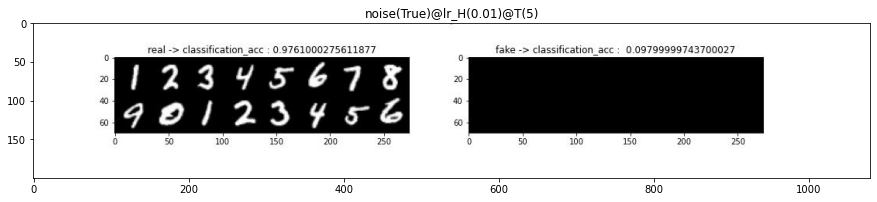

In [122]:
show_results('main', dict_img_position, interested_imgs)
show_results('ht', dict_img_position, interested_imgs)
show_results('overall_results', dict_img_position, interested_imgs)